# Building Micrograd

**Link**: https://www.youtube.com/watch?v=VMj-3S1tku0

In [6]:
import math
import numpy as np
import matplotlib.pyplot as plt
import json
from enum import Enum
from graphviz import Digraph
from collections import deque
%matplotlib inline

# Derivatives

## Simple example
Consider the following function:
$$f(x) = 3x^2 - 4x + 5$$

We can plot it like so:

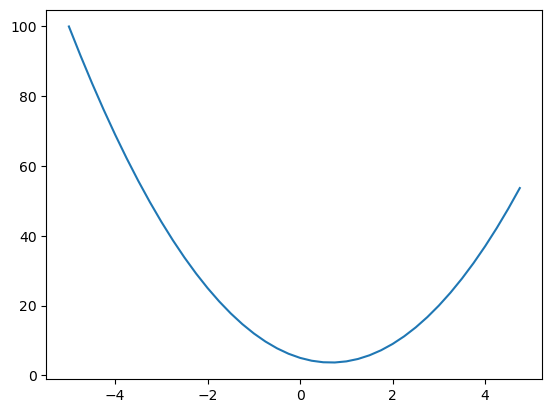

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

Recall the definition of the derivative:
$$f'(x) = \lim_{h \to 0} \frac{f(x+h)-f(x)}{h}$$

So if we wanted to find the (approximate) derivative at any point along the function, we could just use the definition of the derivative like so:

In [3]:
h = 0.000001 # Small h value as a substitute for h -> 0
x = 3.0
(f(x + h) - f(x)) / h

14.000003002223593

Again, this is an approximation, but we can check our work by taking the finding the derivative of `f` and plugging in `x` like we would have done in our high school calculus classes:

$$
\begin{aligned}
f(x) &= 3x^2 - 4x + 5 \hspace{15cm} \\
f'(x) &= 6x - 4 \\
f'(3.0) &= 6(3.0) - 4 \\
f'(3.0) &= 14.0
\end{aligned}
$$

## Partial derivatives
Now let's consider the following equation:
$$
\begin{aligned}
y &= ab + c, \text{ where } \hspace{15cm} \\
a&=2.0, b=-3.0,c=10.0
\end{aligned}
$$

We want to know how $y$ changes with any change to the variables $a$, $b$, and $c$.

Let's start with $a$:

In [4]:
a, b, c = 2.0, -3.0, 10.0
y = a * b + c
# Let's nudge a by a small amount h and see how that changes the output.
h = 0.000001
y_a = (a + h) * b + c
print(f"Slope of a: {(y_a - y)/h}")

Slope of a: -3.000000000419334


So this is saying: if we increase the $a$, then $y_1$ will _decrease_ by a factor of $3$.

Let's continue for $b$ and $c$:

In [5]:
y_b = a * (b + h) + c
print(f"Slope of b: {(y_b - y)/h}")
y_c = a * b + (c + h)
print(f"Slope of c: {(y_c - y)/h}")

Slope of b: 2.000000000279556
Slope of c: 0.9999999992515995


## Implementing the `Value` class

We want to implement our own concept of a "value" in a neural network so that we have control over how it operates. Let's start simple and have this class just store a value and be able to print a string representation of this value:

In [6]:
class Value:
    def __init__(self, value):
        self.value = value

    def __repr__(self):
        s = json.dumps({
            "value": self.value   
        }, indent=2)
        return f"Value: {s}"

In [7]:
a = Value(3.14)
print(a)

Value: {
  "value": 3.14
}


We want to be able to perform operations on our `Value` class. Let's implement the addition, subtraction, multiplication, and division magic methods for this class:

In [8]:
class Value:
    def __init__(self, value):
        self.value = value

    def __add__(self, other):
        return Value(self.value + other.value)

    def __sub__(self, other):
        return Value(self.value - other.value)

    def __mul__(self, other):
        return Value(self.value * other.value)

    def __truediv__(self, other):
        return Value(self.value / other.value)
    
    def __repr__(self):
        s = json.dumps({
            "value": self.value   
        }, indent=2)
        return f"Value: {s}"

In [9]:
a = Value(2.5)
b = Value(7.0)
print(a + b)
print(a - b)
print(a * b)
print(a / b)

Value: {
  "value": 9.5
}
Value: {
  "value": -4.5
}
Value: {
  "value": 17.5
}
Value: {
  "value": 0.35714285714285715
}


> In this notebook, we're going to introduce a concept that will probably be used in the rest of these notes called AAMO (Accept And Move On). It's an amazing learning tool that will save you many hours and much heartache (take it from my experience).

## Children and Operator member variables (AAMO)

We now need our `Value` class to maintain some kind of "memory" of how it was created. Firstly, we need to know what values were involved in creating any given value as well as the operation. If you are familiar in with the concept of backpropagation, you may see why this is necessary. If not, that's okay.

Let's say I have the following equation:
$$ 1 + 2 = 3 $$

This can be modeled with our `Value` class like so:
```python
Value(1) + Value(2) => Value(3)
```

Let's say we take our `Value(3)` and do whatever we like. But let's consider that sometime later we want to refer back to `Value(1)` and `Value(2)` and recall that these `Value` objects were added to create `Value(3)`. A solution to this problem might look like this:

In [37]:
class Op(Enum):
    NONE = 0
    ADD = 1
    SUB = 2
    MUL = 3
    DIV = 4

    def __str__(self):
        match self:
            case Op.NONE:
                return "none"
            case Op.ADD:
                return "addition"
            case Op.SUB:
                return "subtraction"
            case Op.MUL:
                return "multiplication"
            case Op.DIV:
                return "division"
            case _:
                raise ValueError("Unknown operation")
    def opstr(self):
        match self:
            case Op.NONE:
                return ""
            case Op.ADD:
                return "+"
            case Op.SUB:
                return "-"
            case Op.MUL:
                return "*"
            case Op.DIV:
                return "/"
            case _:
                raise ValueError("Unknown operation")    

class Value:
    def __init__(self, value, children=set(), operation=Op.NONE):
        self.value = value
        self.children = children
        self.operation = operation

    def __add__(self, other):
        return Value(
            value=self.value + other.value,
            children={self, other},
            operation=Op.ADD,
        )

    def __sub__(self, other):        
        return Value(
            value=self.value - other.value,
            children={self, other},
            operation=Op.SUB,
        )

    def __mul__(self, other):
        return Value(
            value=self.value * other.value,
            children={self, other},
            operation=Op.MUL,
        )

    def __truediv__(self, other):
        return Value(
            value=self.value / other.value,
            children={self, other},
            operation=Op.DIV,
        )

    def __str__(self):        
        s = json.dumps({
            "value": self.value,
            "children": [json.loads(str(v)) for v in self.children],
            "operation": str(self.operation),
        }, indent=2)
        return s
    
    def __repr__(self):
        return str(self)

    def render_graph(self):
        digraph = Digraph(format="svg", graph_attr={"rankdir": "LR"})
        queue = deque([self])
        while queue:
            current = queue.popleft()
            current_id = str(id(current))
            digraph.node(
                name=current_id,
                label=f"value: {current.value}",
                shape="record",
            )
            if current.operation != Op.NONE:
                op_id = current_id + str(current.operation)
                digraph.node(
                    name=op_id,
                    label=current.operation.opstr(),
                )
                digraph.edge(op_id, current_id)
                for child in current.children:
                    digraph.edge(str(id(child)), op_id)
                    queue.append(child)
        return digraph

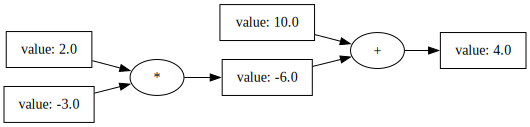

In [39]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
(a*b+c).render_graph()

Left off: https://youtu.be/VMj-3S1tku0?si=CtX3FRI6Ag2HpvYe&t=1553